# Introduction

Time series decomposition은 복잡한 시계열 데이터를 각각의 컴포넌트 파트로 쪼개는 과정입니다. <br> 
수리적으로 표현하면 다음과 같습니다. 

**Additive Decomposition**

$$ y_t = S_t + T_t + C_t + R_t $$

**Multiplicative Decomposition**

$$ \begin{align} y_t &= S_t \times T_t \times C_t  \times R_t \\
\log y_t &= \log S_t + \log T_t \times \log C_t \times \log R_t
\end{align} $$


- $ y_t $ : 데이터
- $ S_t $ : **S**easonal component
- $ T_t $ : **T**rend-cycle component 
- $ C_t $ : **C**yclical component (보통 Cyclical 그리고 Remainder를 합쳐서 Noise 로 보기도 함)
- $ R_t $ : **R**emainder component



1. 이게 무슨 의미? 
    - 시계열 데이터로 예측할때 component를 나눈후 따로따로 데이터를 취급하여 예측력을 높임
2. Additive Decomposition  특징
    - 선형 모델링. 변화가 지속적으로 고르게 일어남. 
3. Multiplicative Decomposition 특징
    - 비선형 모델링. Quadratice 또는 exponential 변화가 일어나는 곳에 쓰임. 
    - 주식은 비선형에 가까움
4. 기타
    - 두개의 decompositions 을 합쳐서 사용하기도 함
    - 현실에서는 그냥 한번에 끝나지 않을수도 있음. <br>decomposition을 하기전에 많은 데이터 전처리가 들어갈수도 있음
   

# Classical Decomposition

1. **Seasonal Period**
    - 분기 데이터: `m = 4` (1분기, 2분기,.. 4분기)
    - 월별 데이터: `m = 12` (1월, 2월.. 12월)
    - 일별 데이터: `m =7` (월, 화, ... 일)

Classical decomposition에서는 **seasonal period값이 상수값**으로 사용합니다. <br>
즉 주가처럼 변화가 심한 것은 다른 알고리즘이 맞음


## Additive Decomposition 

1. Trend Cycle 을 계산
    - $ \hat{T}_t =  MA(m) $
    - 원래 공식은 m이 odd 또는 even이냐에 따라 공식이 달라지는데 그냥 MA구한다고 생각하면 됨 
    - 이유는 예를 들어 MA(5) 라면 앞에 2, 뒤에 2개가 잘려나감. 이것때문에 계산이 좀 달라짐. 
2. Detrended Series 계산 : 
    - Detranded Series = $ y_t - \hat{T}_t $
3. Seasonal Component 계산 
    - 예를 들어 월별 데이터에서 3월의 seasonal 값을 구한다면.. 모든 3월 데이터의 평균값을 구합니다. 
    - 예) (2019년 3월 + 2020년 3월 + 2021년 3월)/3 = averaged seasonality 
4. Remainder Component 계산
    - $ R_t = y_t - \hat{T}_t - \hat{S}_t $
    
* $ MA(m) $ : Moving average of order m -> MA(4) 면 df.rolling(4).mean() 와 유사.. 대신 앞뒤가 짤림

## Multiplicative Decomposition

Additive 와 매우 유사합니다. 

1. MA계산. 
2. Detrended Series = $ y_t\ / \ \hat{T}_t $
3. Additve decomposition과 동일
4. $ R_t = y_t \big/ \left(\hat{T}_t \times \hat{S}_t \right) $

## 의견

1. Classical decomposition은 자주 사용되나 추천은 안함. 이유.. 
    1. MA를 구하면서 앞, 뒤 데이터가 잘려나감 
    2. Seasnal change에 약함. <br>예를들어 60년대 전기 사용이 겨울철이 많았다면, <br>현재는 에어컨 사용으로 여름에 더 전기 사용량이 많음. <br>-> classical decomposition이 이런 변화에 약함
    3. 항공 산업 전체에서 일시적인 파업등으로 일부 데이터가 잠시 변화가 있을시.. 여기에 robust하게 대처 못함


## Python Code

In [1]:
import numpy as np
import pandas as pd
import yfinance
import kaggle.api as kaggle
import matplotlib.pylab as plt 

from tempfile import gettempdir
from pathlib import Path


# Air Passengers Data
data_path = Path(gettempdir()) / 'AirPassengers.csv'
kaggle.authenticate()
kaggle.dataset_download_files('rakannimer/air-passengers', data_path.parent, unzip=True)
air_df = pd.read_csv(data_path, index_col=0)
air_df.index = pd.to_datetime(air_df.index)

# Stock Data
stock = yfinance.Ticker('000660.KS')
stock = stock.history(period='1y')
stock.index = pd.to_datetime(stock.index)

### Additive Decomposition for Air Passengers 

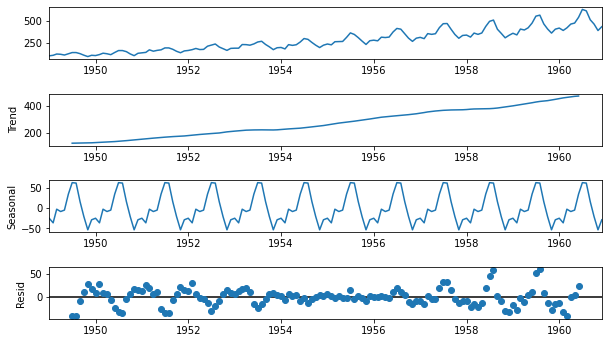

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 월별 데이터라서  period=12 로 잡음. 값 안넣어도 자동으로 12로 잡힘
# model="multiplicative" 넣으면 multiplicative decomposition 함
dec = seasonal_decompose(air_df, model='additive', period=12)
fig = dec.plot()
fig.set_size_inches(9, 5)

### Multiplicative for Stock

Residual 부분이 1에 많이 분포해 있는데.. 'additive'로 변경하면 Air Passenger처럼 그려짐

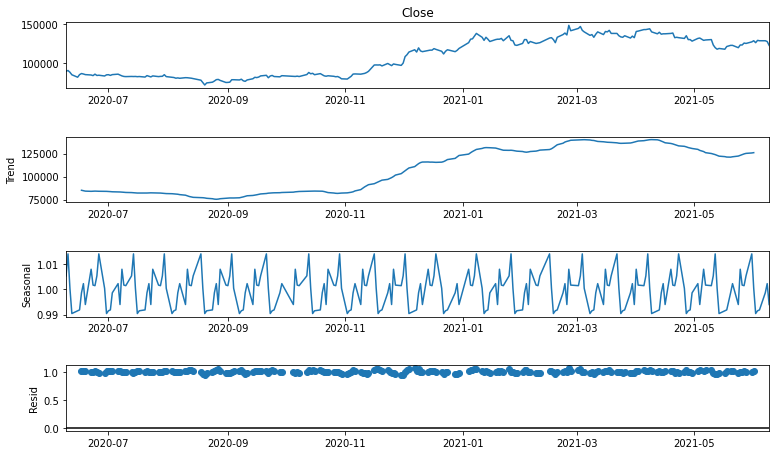

In [3]:
dec = seasonal_decompose(stock.Close, model='multiplicative', period=12)
fig = dec.plot()
fig.set_size_inches(12, 7)

# Filters 

## Hodrick Prescott Filter

Data Smoothing technique 으로 주로 사용되며, short-term fluctuations을 제거하는데 사용됩니다. <br> 
<span style="color:red">아래 공식을 보면 T_{t+1} - T_t 부분이 있는데, 미래시점의 데이터를 가져와서 계산을 합니다.<br>
즉 Forecasting 모델에 사용시 해당 필터를 사용시 미래시점의 정보를 이미 input에 갖고 있기 때문에 사용하면 안됩니다.</span>

$$ y_t = T_t + C_t $$

- $ T_t $ : Trend
- $ C_t $ : Cycle

위의 공식처럼 구성되어 있으며, 최적화하는 방법에 있어서 아래의 Quadratic loss function을 minimize 합니다. <br> 
이때 $ \lambda $ 는 smoothing parameter 입니다. 

$$ \min \sum^T_{t=1} (x_t - T_t)^2 + \lambda \sum^T_{t=1} \left[ (T_{t+1} - T_{t}) - (T_{t} - T_{t-1}) \right]^2 $$

Lambda 는 다음과 같이 사용합니다. 

- Quarterly Data (기본값): **1600**
- Monthly Data: **129600** ( $ 1600 \times 3^4 $ )
- Annual Data: **6.25** ( $ 1600\ /\ 4^4 $ )

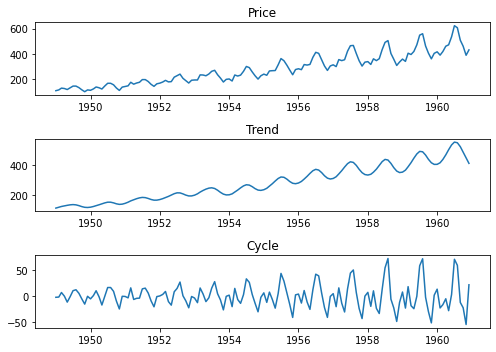

In [4]:
from statsmodels.tsa.filters.hp_filter import hpfilter

cycle, trend = hpfilter(air_df, lamb=6.25)

# Visualization
fig, ax = plt.subplots(3, 1, figsize=(7, 5))
fig.set_tight_layout(True)
ax[0].plot(air_df)
ax[0].set_title('Price')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
print()

## Christiano Fitzgerald asymmetric, random walk filter

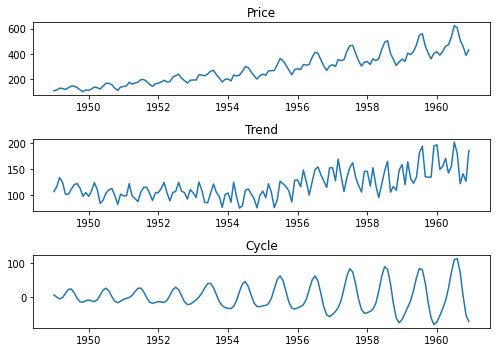

In [5]:
from statsmodels.tsa.filters.cf_filter import cffilter

cycle, trend = cffilter(air_df, low=6)

# Visualization
fig, ax = plt.subplots(3, 1, figsize=(7, 5))
fig.set_tight_layout(True)
ax[0].plot(air_df)
ax[0].set_title('Price')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
print()

# STL Decomposition

STL은 "Seasonal and Trend Decomposition Using Loess"의 약자 이며, <br>
Loess method는 Non-linear 데이터에 사용됩니다. <br>
STL은 기존의 classical decomposition, X11, SEATS 등의 알고리즘보다 좋은 어드벤티지를 갖습니다. 

1. Advantages
    1. X11, SEATS등은 특히 monthly, quaterly 에만 사용이 가능하지만, <br>STL의 경우 모든 타입의 seasonality 데이터에 적용이 가능
    2. Seasonal component는 시간에 따라 변화하며, 변화량 자체를 유저가 설정 가능
    3. Trend-Cycle의 smoothness또한 사용자에 의해서 컨트롤이 가능
    4. Outliers에 robust합니다. 즉 레어한 케이스로 일어나는 급작스러운 변화에 trend-cycle 또는 seasonality에 영향을 주지 않습니다.다만 remainder component에는 영향을 미칩니다. 
2. Disadvantages
    1. 주가의 경우 토요일, 일요일 같은 데이터가 없는데.. 이런 캘린더상의 데이터를 잘 처리하지 못함. <br>따라서 STL에 넣기전에 그냥 일별 데이터로 전부다 만들어준다음에 넣어야 함

## Python Code

### STL for Air Passengers

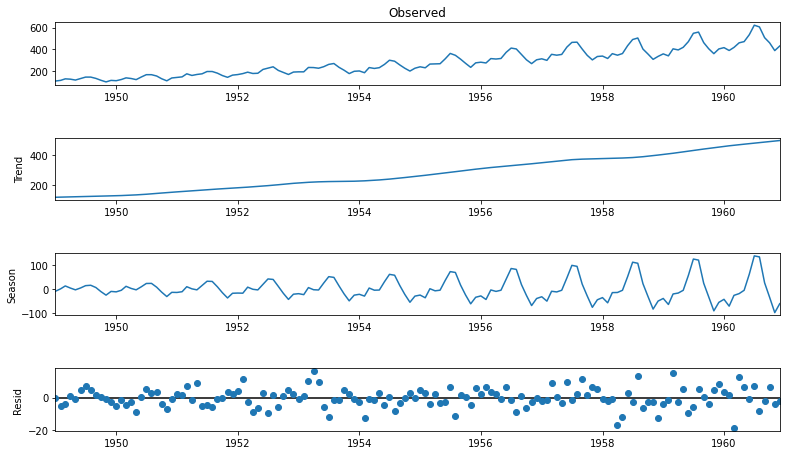

In [6]:
from statsmodels.tsa.seasonal import STL

stl = STL(air_df, seasonal=13)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(12, 7)

### Recompose 

Decomposition 으로 시계열 데이터를 분리 했다면.. 다시 합치는 것도 가능.  
다만 recompose 시키면서.. 아주 작은 소수점 정도가 틀려 질수 있습니다. <br> 
따라서 예측 분야가 아니라.. 아주 정밀한 작업을 요할때는 사용 불가능

In [7]:
stl = STL(air_df, seasonal=13)
res = stl.fit()

# 합치기 
recomposed_series = res.trend + res.seasonal + res.resid

# 검증
(recomposed_series.values != air_df.values).sum() 
df = pd.DataFrame({'recomposed': recomposed_series, 'air': air_df['#Passengers']})
df['diff'] = df['recomposed'] - df['air']
df[df['diff'] != 0]

,recomposed,air,diff
Month,,,
1949-11-01,104.0,104,1.421085e-14
1950-02-01,126.0,126,-1.421085e-14
1953-02-01,196.0,196,-2.842171e-14
1953-09-01,237.0,237,2.842171e-14
1955-11-01,237.0,237,-2.842171e-14
1957-09-01,404.0,404,5.684342e-14
1958-01-01,340.0,340,5.684342e-14


### STL Robust Fitting for Stock

 - 주가에 robust 옵션이 뭐 그닥 

{'period': 5,
 'seasonal': 5,
 'seasonal_deg': 1,
 'seasonal_jump': 1,
 'trend': 11,
 'trend_deg': 1,
 'trend_jump': 1,
 'low_pass': 7,
 'low_pass_deg': 1,
 'low_pass_jump': 1,
 'robust': True}

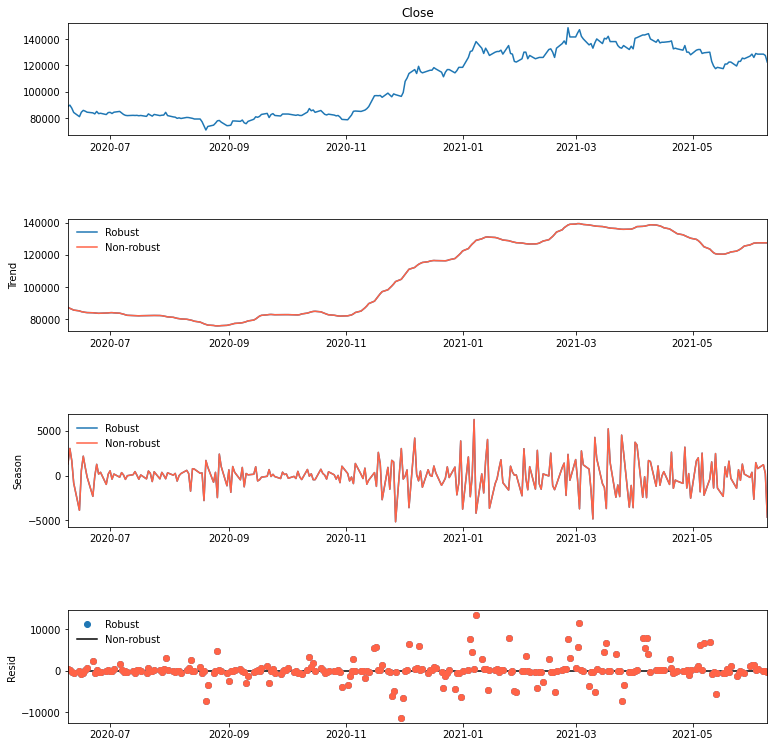

In [8]:
def preprocess(df):
    """
    주가 데이터 전처리
     - 월~금까지 데이터를 남겨두고 지운다. 
     - 휴장일의 경우 전날의 데이터를 그대로 사용
     - 이렇게 하는 이유는 5일 로테이션을 맞추기 위해서 (Seasonality)
    """
    df = df.copy()
    datetime_index = pd.DatetimeIndex(pd.date_range(df.index[0], df.index[-1]))
    
    df = df.reindex(datetime_index)
    df = df.loc[~df.index.weekday.isin({5, 6})]
    
    df.fillna(method='ffill', inplace=True)
    df.index.name = 'datetime'
    return df

def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none', color='tomato')
        else:
            ax.plot(series, color='tomato')
        
        ax.legend(legend, frameon=False)

df = preprocess(stock)

stl = STL(df.Close, seasonal=5, robust=True)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(12, 12)


add_stl_plot(fig, res, ['Robust', 'Non-robust'])
display(stl.config)
# stock.reset_index(drop=True).set_index('Date', inplace=True)

## Anomaly Detection

In [89]:
stock = yfinance.Ticker('000660.KS')
stock = stock.history(period='2y')
stock.index = pd.to_datetime(stock.index)

df = preprocess(stock)

stl_open = STL(df.Open, seasonal=5, robust=True).fit()
stl_close = STL(df.Close, seasonal=5, robust=True).fit()

In [109]:
residual_std = stl_open.resid.rolling(7).std()

up_df = stock.loc[stl_open.resid < residual_std*1.5]

(up_df.Close/up_df.Open -1).round(2).mean()

0.00045766590389016026

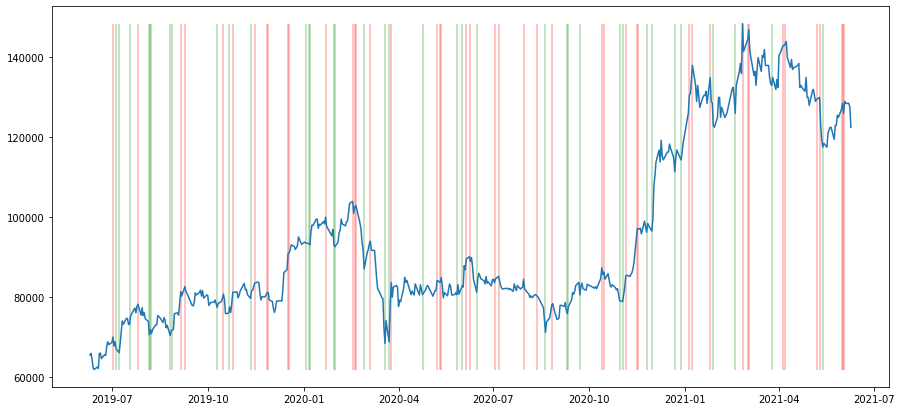

In [93]:
residual_std = stl_close.resid.rolling(12).std()

anomaly_up = stock.loc[(stl_close.resid >= residual_std*1.5)]
anomaly_down = stock.loc[(stl_close.resid < -residual_std*1.5)]
ymin = stock.Close.min()
ymax = stock.Close.max()

fig, ax = plt.subplots(1, figsize=(15, 7))
for idx in anomaly_up.index:
    x = ax.vlines(idx, ymin=ymin, ymax=ymax, color='red', alpha=0.3)
for idx in anomaly_down.index:
    x = ax.vlines(idx, ymin=ymin, ymax=ymax, color='green', alpha=0.3)
    
ax.plot(stock.Close)